In [1]:
# Add a button to hide / show code blocks 
import IPython.core.display as di 
di.display_html('''<button id="showHideCodeButton" class="jupyter-widgets jupyter-button widget-button" onclick="
                    jQuery('.input').toggle(); jQuery('.prompt').toggle();                    
                    var visibleElements = jQuery('.prompt').find(':visible').not('script');
                    if (this.innerHTML == 'Show code') this.innerHTML = 'Hide code';
                    else this.innerHTML = 'Show code';">Hide code</button>''', raw=True)

Hide code

# SYNERGY Summer School Combinatorial

The notebook presents the optimization of simplified real-world problem (Production Scheduling) with a multiobjective optimization algorithm (NSGA-II).

# NSGA-II Algorithm

K. Deb, S. Agrawal, A. Pratab and T. Meyarivan, "A fast and elitist multiobjective genetic algorithm: NSGA-II," 
IEEE Transactions on Evolutionary Computation, Vol. 6, No. 2, pp. 182-197, 2002. http://ieeexplore.ieee.org/document/996017/

## Algorithm Implementation: DEAP Package

- https://github.com/DEAP/deap
- https://deap.readthedocs.io/en/master/
- https://github.com/DEAP/deap/blob/master/examples/ga/nsga2.py

In [2]:
from IPython.display import IFrame
from IPython.display import display
import os

def display_iframe(src, width='100%', height=600):    
    if 'BINDER_URL' in os.environ:
        prepend = 'https://rawgit.com/synergy-twinning/summer-school-combinatorial/master/'
        source = prepend + src
    else:
        source = src        
    display(IFrame(source, width=width, height=height));

display_iframe("NSGA-II.pdf")

# Test Problem


### Production Scheduling Optimization

Orders must be scheduled in many production lanes. The total time of production is determined by the last order being produced. 

The problem has many orders that consist of different products that need to be processed in time on available production lanes. 
One of the two objectives is to minimize the time of production and other is to minimize the number of overdue order.

https://www.sciencedirect.com/science/article/pii/S0957417413003321/pdfft?md5=3ec498119be58a1a2266afa214c81dde&pid=1-s2.0-S0957417413003321-main.pdf

In [3]:
display_iframe("production_scheduling.pdf")

In [4]:
##################################
# 
# Imports
#
##################################

%matplotlib notebook

import array
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, tanh
import os
import ctypes

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

from ipywidgets import widgets, Layout, Button, Box
import numpy as np

import warnings
warnings.simplefilter('ignore')

C:\Anaconda3\envs\tensorflow\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [5]:
def generate_random_production_capacities(number_of_lanes, number_of_products, number_of_orders, 
                                          seed=None, min_lane_time=2, max_lane_time=6, min_quantity=3, max_quantity=8,
                                          min_deadline=50, max_deadline=80):
    """Returns matrix of size number_of_products x number_of_lanes 
    where each entry represents the time that a certain lane needs 
    to produce a certain product. If a value in the matrix is equal
    to infinity, then that lane can't produce the corresponding product.

    The function also returns a list of orders that have to be executed. 
    Each order is described with the tuple (product, quantity, deadline)."""
    if seed is not None:
        np.random.seed(seed)
    P = np.random.randint(min_lane_time, high=max_lane_time, size=(number_of_products, number_of_lanes)).astype(float)
    # Set some of the values to inf
    for i in range(number_of_products):
        for j in np.random.choice(list(range(number_of_lanes)), size=int(0.5*number_of_lanes)):
            P[i,j] = np.inf
    O = []
    for _ in range(number_of_orders):
        product = np.random.randint(0, number_of_products)
        quantity = np.random.randint(min_quantity, max_quantity)
        O.append((product, quantity, np.random.randint(min_deadline, max_deadline)))
    return P, O

In [6]:
class ProgramEvaluator:
    """Class used to evaluate, mutate, cross and generate new schedules."""
    def __init__(self, P, O, switching_products_penalty=2):
        self.P = P
        self.O = O
        self.number_of_lanes = P.shape[1]
        self.number_of_products = P.shape[0]
        self.switching_products_penalty = switching_products_penalty
        
    def total_time_per_lane(self, lanes):
        """Returns the time of the last executed order for each of the lanes"""
        lane_times = []
        for i, lane in enumerate(lanes):
            total = 0
            for product, quantity, deadline in lane:
                total+=self.P[product, i]*quantity
                
            for j in range(len(lane)-1):
                product1, _, _ = lane[j]
                product2, _, _ = lane[j+1]
                if product1!=product2:
                    total+=self.switching_products_penalty
                
                
            lane_times.append(total)
        return lane_times
    
    def order_overdue(self, lanes):
        """Returns dictionary where keys are orders that were finished after deadline and values are delays."""
        dc  = dict()
        for i, lane in enumerate(lanes):
            total = 0
            if len(lane)>0:
                prev_product,_,_ = lane[0]
                for order in lane:
                    product, quantity, deadline = order
                    total+=self.P[product, i]*quantity
                    if prev_product!=product:
                        total+=self.switching_products_penalty
                    prev_product=product
                    # Ignore orders that were executed in time
                    if total>deadline:
                        dc[order]=total-deadline
        return dc
    
    def generate_init_solution(self):
        """Construct a random vector of length 2*number_of_orders. 
        Hirst half of the vector symbolizes the lane on which each
        order is produced. The second half of the vector is the priority of each order. 

        Example:
        o = [A, B, C, D, E]
        x = [0, 1, 2, 1, 1,    3, 4, 2, 0 , 1]

        Schedule:
        L0 [A]
        L1 [D, E, B] #Note the priority of execution
        L2 [C]
        """
        lane_vec = []
        # For each product, choose a random lane that can execute this order.
        for product, quantity, deadline in self.O:
            # All possible lanes
            possible_lanes = np.argwhere(self.P[product, :]<np.inf).flatten().tolist()
            if len(possible_lanes)==0:
                raise ValueError("No lane can produce a product.")
            random.shuffle(possible_lanes)
            lane_vec.append(possible_lanes[0])
        # Shuffled random vector of priorities
        priority = list(range(len(self.O)))
        random.shuffle(priority)
        # Return merges vector
        return lane_vec + priority
    
    def mutation(self, x, lane_probability=0.1, priority_probability=0.2):
        """Takes one individual from the population and constructs
        a new individual that has some of its properties changed. 
        Generated individual must be valid."""      
        # Lanes of executions
        lane_to_execute_on = x[:len(self.O)]
        # Priorities
        order_of_executions = x[len(self.O):]
        
        # New lane distribution
        lane_to_execute_on_new = []
        for old_lane, (product, quantity, deadline) in zip(lane_to_execute_on, self.O):
            possible_lanes = np.argwhere(self.P[product, :]<np.inf).flatten().tolist()
            random.shuffle(possible_lanes)
            # Switch lane with probability prob_lane_change
            if random.random() <= lane_probability:
                lane_to_execute_on_new.append(possible_lanes[0])
            else:
                lane_to_execute_on_new.append(old_lane)
        
        # Swap priorities with probability prob_priority_swap
        for i in range(len(order_of_executions)):
            if np.random.rand()<priority_probability:
                j = np.random.randint(0, len(order_of_executions))
                # Swap with random element
                tmp = order_of_executions[i]
                order_of_executions[i] = order_of_executions[j]
                order_of_executions[j] = tmp
        
        for i, val in enumerate(lane_to_execute_on_new+order_of_executions):
            x[i] = val
                
        #return lane_to_execute_on_new+order_of_executions
        return x
    
    def crossover(self, x1, x2):
        """Takes 2 individual from the population and constructs
        2 new individuals that are similar to their parents."""
        if len(x1)!=2*len(self.O):
            raise ValueError("Input vector should 2x larger than the size as the number of orders.")
        if len(x2)!=2*len(self.O):
            raise ValueError("Input vector should 2x larger than the size as the number of orders.")
        
        lane_to_execute_on1 = x1[:len(self.O)]
        order_of_executions1 = x1[len(self.O):]

        lane_to_execute_on2 = x2[:len(self.O)]
        order_of_executions2 = x2[len(self.O):]
        
        # Cut vectors at random point and combine them to form new individuals
        cut1 = np.random.randint(1, high=len(lane_to_execute_on2)-1)
        a = lane_to_execute_on1[0:cut1]+lane_to_execute_on2[cut1:]
        b = lane_to_execute_on2[0:cut1]+lane_to_execute_on1[cut1:]
        
        cut2 = np.random.randint(1, high=len(lane_to_execute_on2)-1)
        o1 = order_of_executions1[0:cut2]
        o2 = order_of_executions2[0:cut2]
        
        for x in order_of_executions2:
            if x not in o1:
                o1.append(x)
                
        for x in order_of_executions1:
            if x not in o2:
                o2.append(x)

        for i, val in enumerate(a+o1):
            x1[i] = val
            
        for i, val in enumerate(b+o2):
            x2[i] = val
        
        return [a+o1, b+o2]

    def evaluate(self, x):
        """Evaluate schedule represented as a vector. The first half of the vector 
        represents the assignment of each order to a certain lane. If the order can't
        be finished on the assigned lane, then the solution is invalid. The second part
        of the schedule is the priority of orders. Orders with the smallest number will
        be executed first. The second part of the vector is a set of numbers 
        from 0 to n that determine priority of each order."""
        if len(x)!=2*len(self.O):
            raise ValueError("Input vector should 2x larger than the size as the number of orders.")
        lane_to_execute_on = x[:len(self.O)]
        order_of_executions = x[len(self.O):]
        
        # Reorder to lanes and sort
        lanes = [[] for _ in range(self.number_of_lanes)]
        tmp_lane = [[] for _ in range(self.number_of_lanes)]
        for lane, col in zip(lane_to_execute_on, list(zip(order_of_executions, self.O))):
            tmp_lane[lane].append(col)
        for i, l in enumerate(tmp_lane):
            for p, x in sorted(l):
                lanes[i].append(x)

        totals = self.total_time_per_lane(lanes)
        orders_over = self.order_overdue(lanes)
        # Return time of the longest executing lane. 
        o1 = np.max(totals)
        # Return the summed time of all missed deadlines.
        o2 = np.sum(list(orders_over.values()))
        return [o1, o2] 

In [7]:
P, O = generate_random_production_capacities(3, 7, 4, seed=2001)

A matrix of size $number\_of\_products \times number\_of\_lanes$, where each entry is the time it takes to produce a certain product on the specific lane.

In [8]:
P

array([[  2.,   2.,  inf],
       [ inf,   4.,   4.],
       [  3.,  inf,   3.],
       [  2.,  inf,   2.],
       [  5.,   2.,  inf],
       [  5.,  inf,   3.],
       [  2.,  inf,   5.]])

List of orders where each order is a tuple of 3 values $(product, quantity, deadline)$.

In [9]:
O

[(6, 3, 75), (6, 5, 55), (0, 4, 57), (0, 3, 72)]

In [10]:
pe = ProgramEvaluator(P, O)
s = pe.generate_init_solution()

In [11]:
print("Schedule", s)
print(pe.evaluate(s))

Schedule [2, 2, 1, 1, 2, 0, 1, 3]
[40.0, 0.0]


In [12]:
##################################
# 
# Algorithm Set Up
#
# Change this code to change the definition of the optimization problem, e.g., the attribute bounds.
# Set use_external_library_for_evaluation to True if external libraries (.dll or .so) are to be used for evaluating 
# the solutions. If it is set to False, the Python code is used for evaluation. 
#
##################################

capacities, orders = generate_random_production_capacities(number_of_lanes=4,number_of_products=7, number_of_orders=35, seed=42)
pe = ProgramEvaluator(capacities, orders)

optimization_type = (-1.0, -1.0)  # -1..minimization, 1..maximization
objective_name = ["Total time", "Overdue deadline"]
objective_limit = [[0, 400], [0, 1700]]
reference_point = [objective_limit[0][1], objective_limit[1][1]]
hypervolume_upper_limit = reference_point[0] * reference_point[1]

In [13]:
##################################
# 
# NSGA-II Algorithm
#
# Change this code to change the initialization of solutions and population, to change the evaluation function, 
# to use other crossover, mutation or selection operators, to change the evolution of solutions through generations,
# to change the plots of the results.
#
##################################

##################################
# global definitions
##################################
creator.create("FitnessMax", base.Fitness, weights=optimization_type)
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("individual", lambda ins: ins(pe.generate_init_solution()), creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate", pe.mutation)
toolbox.register("mate", pe.crossover)
toolbox.register("evaluate", pe.evaluate)
toolbox.register("select", tools.selNSGA2)

In [14]:
##################################
# 
# Auxiliary Functions
#
##################################
def fitness_data(population):
    fitness_array_data = []
    for individual in population:
        fitness_array_data += [individual.fitness.values]    
    fitness_array_data = np.array(fitness_array_data)
    return fitness_array_data


def plot_data(plot, data, marker, label1, color1):
    plot.plot(data[:,0], data[:,1], marker, color=color1, label=label1) 

# Algorithm Evaluation

<IPython.core.display.Javascript object>


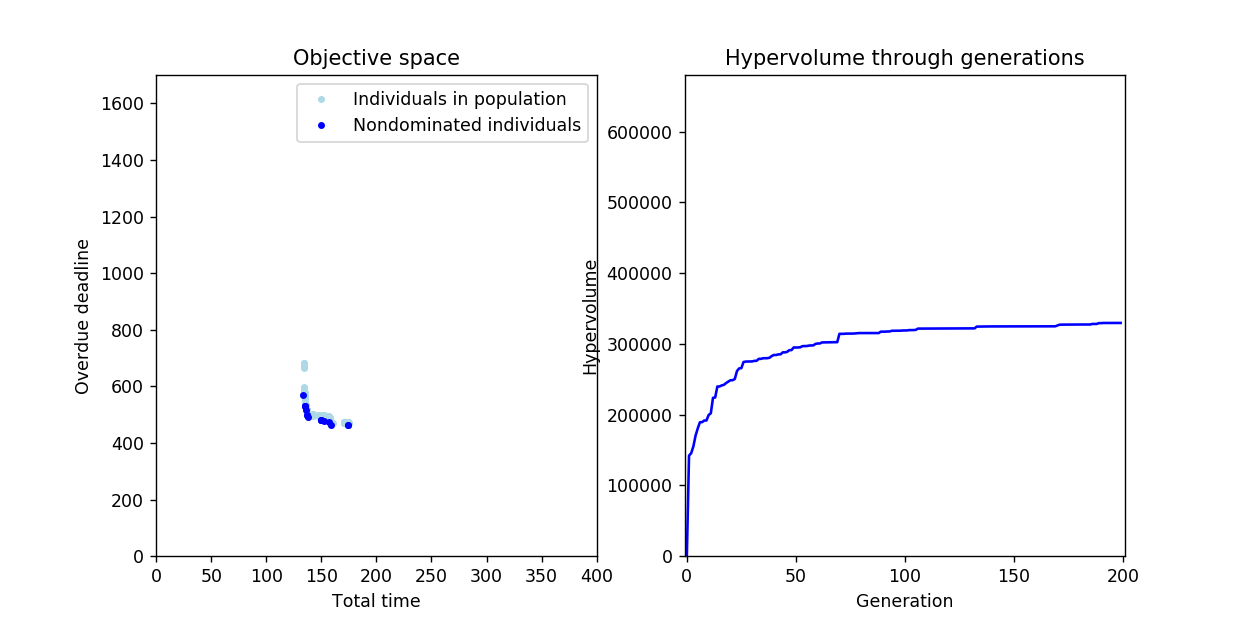

Population size: 100
Number of generations: 100
Crossover probability: 0.3
Mutation probability - lane change: 0.15
Mutation probability - priority change: 0.2
Final hypervolume: 270059.000000
****************************************
Population size: 280
Number of generations: 200
Crossover probability: 0.48
Mutation probability - lane change: 0.33
Mutation probability - priority change: 0.39
Final hypervolume: 256049.000000
****************************************
Population size: 280
Number of generations: 200
Crossover probability: 0.07
Mutation probability - lane change: 0.06
Mutation probability - priority change: 0.11
Final hypervolume: 326552.000000
****************************************
Population size: 400
Number of generations: 200
Crossover probability: 0.06
Mutation probability - lane change: 0.05
Mutation probability - priority change: 0.08
Final hypervolume: 329652.000000
****************************************


In [15]:
######################################### 
# 
# This code provides a graphical interface for testing various configurations of parameters of the NSGA-II algorithm.
# Four parameters can be manually tuned: 
#   - population size
#   - number of generations 
#   - crossover probability
#   - mutation probability
#
# The NSGA-II algorithm is executed by calling the function "optimize" that returns the hypervolume
#
##################################

def optimize(population_size, 
             number_of_generations,
             crossover_probability, 
             mutation_probability_lanes, 
             mutation_probability_priority):
    
    # initialize population with pop_size solutions
    population = toolbox.population(n=population_size)

    # evaluate the solutions
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
        
    # use this procedure just to assign crowding distance
    population = toolbox.select(population, len(population))

    # save hypervolume
    hypervolume_history = np.array([[0,0]])

    # begin generational process
    for generation in range(1, number_of_generations):
        # tournament selection based on dominance (D) between two solutions, 
        # if the two solutions do not interdominate the selection is made based on crowding distance (CD)
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = [toolbox.clone(ind) for ind in offspring]
   
        # for every consecutive pair of offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            # perform crossover
            if random.random() <= crossover_probability:
                toolbox.mate(ind1, ind2)

            # perform mutation
            toolbox.mutate(ind1, mutation_probability_lanes, mutation_probability_priority)
            toolbox.mutate(ind2, mutation_probability_lanes, mutation_probability_priority)

        # evaluate solutions
        fitnesses = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # select next generation population
        population = toolbox.select(population + offspring, population_size)        
        
        # find nondominated solutions
        nondominated_individuals = tools.sortNondominated(population, len(population))[0]
        
        # plot data
        hypervolume_subfigure.clear()
        objective_space_subfigure.clear()
        hypervolume_value = hypervolume(population, reference_point)
        hypervolume_history = np.append(hypervolume_history,np.array([[generation, hypervolume_value]]), axis = 0) 
        plot_data(hypervolume_subfigure, hypervolume_history, '-', 'hypervolume', 'b')   
        hypervolume_subfigure.set_title('Hypervolume through generations')
        hypervolume_subfigure.set_xlabel('Generation')
        hypervolume_subfigure.set_ylabel('Hypervolume')
        hypervolume_subfigure.set_xbound([-1, number_of_generations+1])
        hypervolume_subfigure.set_ybound([0, hypervolume_upper_limit])
        
        pop_fitness_data_all = fitness_data(population)         
        plot_data(objective_space_subfigure, pop_fitness_data_all, '.', 'Individuals in population', 'lightblue')  
        pop_fitness_data_nondominated = fitness_data(nondominated_individuals)         
        plot_data(objective_space_subfigure, pop_fitness_data_nondominated, '.', 'Nondominated individuals', 'b')  
        objective_space_subfigure.set_title('Objective space')
        objective_space_subfigure.set_xlabel(objective_name[0])
        objective_space_subfigure.set_ylabel(objective_name[1])
        objective_space_subfigure.set_xbound(objective_limit[0])
        objective_space_subfigure.set_ybound(objective_limit[1])
        objective_space_subfigure.legend()
        main_figure.canvas.draw() 
    
    return hypervolume_value

population_size_label = widgets.Label(value="Population size:")
population_size_slider = widgets.IntSlider(value=100, min=20, max=400, step=20, disabled=False, continuous_update=False, 
                            orientation='horizontal', readout=True, readout_format='d')
number_of_generations_label = widgets.Label(value="Number of generations:")
number_of_generations_slider = widgets.IntSlider(value=100, min=20, max=200, step=20, disabled=False, continuous_update=False, 
                            orientation='horizontal', readout=True, readout_format='d')
crossover_probability_label = widgets.Label(value="Crossover probability:")
crossover_probability_slider = widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.01, disabled=False, 
                                    continuous_update=False, orientation='horizontal',readout=True, readout_format='.2f')
mutation_lane_probability_label = widgets.Label(value="Mutation probability - lane change:")
mutation_lane_probability_slider = widgets.FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, disabled=False, 
                                    continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')

mutation_priority_probability_label = widgets.Label(value="Mutation probability - priority change:")
mutation_priority_probability_slider = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, disabled=False, 
                                    continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')

evolution_button = Button(description='Start evolution')

box_layout = Layout(display='flex', flex_flow='column', align_items='center', border='none',width='100%')

label_box = widgets.VBox([population_size_label, number_of_generations_label, crossover_probability_label,
                         mutation_lane_probability_label, mutation_priority_probability_label])
slider_box = widgets.VBox([population_size_slider, number_of_generations_slider, crossover_probability_slider, 
                          mutation_lane_probability_slider, mutation_priority_probability_slider])
label_slider_box = widgets.HBox([label_box, slider_box])

main_figure = None
objective_space_subfigure = None
hypervolume_subfigure = None

def on_button_clicked(b):
    global main_figure
    global objective_space_subfigure
    global hypervolume_subfigure
    if main_figure is None:
        main_figure = plt.figure(figsize=(10,5))
        objective_space_subfigure = main_figure.add_subplot(121)
        hypervolume_subfigure = main_figure.add_subplot(122)
        plt.ion()
        main_figure.show()
        main_figure.canvas.draw() 
    evolution_button.disabled = True
    evolution_button.description = "Evolution in progress..."
    print("Population size: "+str(population_size_slider.value))
    print("Number of generations: "+str(number_of_generations_slider.value))
    print("Crossover probability: "+str(crossover_probability_slider.value))
    print("Mutation probability - lane change: "+str(mutation_lane_probability_slider.value))
    print("Mutation probability - priority change: "+str(mutation_priority_probability_slider.value))
    hypervolume_value = optimize(population_size_slider.value, number_of_generations_slider.value, 
                                 crossover_probability_slider.value, mutation_lane_probability_slider.value,
                                 mutation_priority_probability_slider.value)
    print("Final hypervolume: %f" % hypervolume_value)
    print("****************************************")
    evolution_button.description = "Start evolution"
    evolution_button.disabled = False

evolution_button.on_click(on_button_clicked)

top_label = widgets.Label(value="Optimization parameters", layout=Layout(width='80%'))

box_all = Box(children=[top_label, label_slider_box, evolution_button], layout=box_layout)
box_all

In [16]:
%%javascript
//Hide the code blocks. 
//Example of usage: At the beginning, click on Cell -> Run All. In this case, all the code blocks will be hidden
var visibleElements1 = jQuery('.prompt').find(':visible').not('script');
jQuery('.input').toggle(); 
jQuery('.prompt').toggle();
var visibleElements2 = jQuery('.prompt').find(':visible').not('script');
if (visibleElements2.length > visibleElements1.length)
{
    jQuery('.input').toggle(); 
    jQuery('.prompt').toggle();
}
var button1 = document.getElementById("showHideCodeButton")
button1.innerHTML = 'Show code';

<IPython.core.display.Javascript object>